In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.src.utils.module_utils import tensorflow

from tensorflow.keras import models, layers, Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.feature_extraction.text import CountVectorizer

from Code.utils.dataset import Dataset

[nltk_data] Downloading package punkt to C:\Users\Guilherme
[nltk_data]     Barbosa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
np.random.seed(42)
tensorflow.random.set_seed(42)
random.seed(42)

In [ ]:
def build_model(hp):
    min_hidden = 20
    max_hidden = 40

    n_features = X_train.shape[1]

    model = models.Sequential()
    model.add(Input((n_features,)))
    # hp1_units = hp.Int('hidden1_units', min_value=min_hidden, max_value=max_hidden, step=1)
    model.add(layers.Dense(38, activation='relu'))

    # hp_dropout1 = hp.Float('dropout1', min_value=0.2, max_value=0.8, step=0.1)
    # model.add(layers.Dropout(rate=hp_dropout1))

    # hp2_units = hp.Int('hidden2_units', min_value=min_hidden, max_value=max_hidden, step=1)
    model.add(layers.Dense(27, activation='sigmoid'))

    # hp_dropout2 = hp.Float('dropout2', min_value=0.2, max_value=0.8, step=0.1)
    # model.add(layers.Dropout(rate=hp_dropout2))

    # hp3_units = hp.Int('hidden3_units', min_value=min_hidden, max_value=max_hidden, step=1)
    model.add(layers.Dense(31, activation='relu'))
    # hp4_units = hp.Int('hidden4_units', min_value=min_hidden, max_value=max_hidden, step=1)
    model.add(layers.Dense(21, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate
    learning_rate_options = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.15, 0.2]
    momentum_options = [0.8, 0.85, 0.9, 0.95]
    hp_learning_rate = hp.Choice('learning_rate', values=learning_rate_options)
    #hp_momentum = hp.Choice('momentum', values=momentum_options)

    optimizer = optimizers.Adamax(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model

In [3]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

# Remover pontuação deu pior resultado
X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets('Text', 'Label', sep='\t', rem_punctuation=False)

In [ ]:
# Start tuner

tuner = kt.Hyperband(
    build_model,
    objective='acc',
    max_epochs=20,
    factor=3,
    directory='./KerasTuner',  # Directory to store results
    project_name='DNN_Tuning',
    seed=42
)

tuner.search(X_train, y_train, epochs=20, batch_size=24, validation_data=(X_validation, y_validation))

Hidden Layer 1 has 38 units
Hidden Layer 2 has 27 units
Hidden Layer 3 has 31 units
Hidden Layer 4 has 21 units
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - acc: 0.4898 - loss: 0.7208 - val_acc: 0.5000 - val_loss: 0.6387
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.6251 - loss: 0.6054 - val_acc: 0.9880 - val_loss: 0.4819
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9991 - loss: 0.4427 - val_acc: 0.9980 - val_loss: 0.3336
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.0000 - loss: 0.2987 - val_acc: 0.9990 - val_loss: 0.2227
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 0.1986 - val_acc: 1.0000 - val_loss: 0.1557
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.0000 - loss: 0.1398 - val_acc: 1.0000 - val_loss: 0.1155
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.0000 - loss: 0.1045 - val_acc: 1.0000 - val_loss: 0.0902
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.

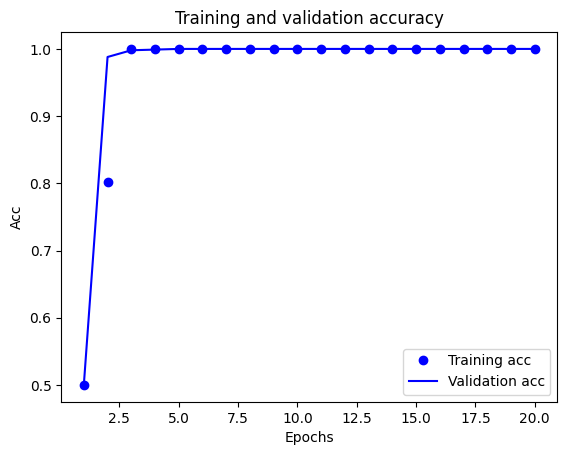

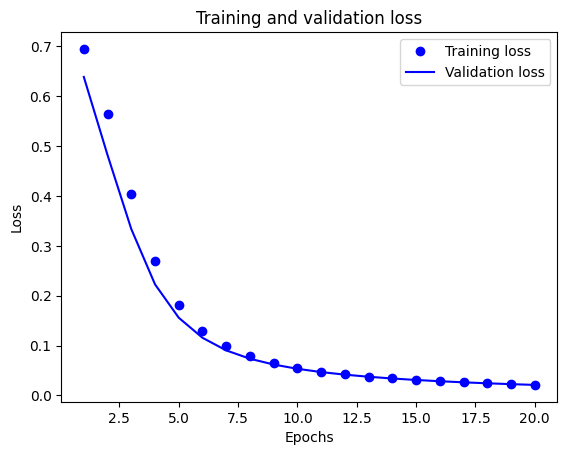

In [4]:
# 2 Layers: Hidden1=(units=16, activation=relu), Hidden2=(units=6, activation=relu), exit=(units=1, activation='relu'), epochs=20, batch_size=512, optimizer=default_rmsprop, prev: 80% no dataset1_inputs(phase1) do stor
# 2 Layers: Hidden1=(units=70, activation=relu), Hidden2=(units=18, activation=relu), exit=(units=1, activation='relu'), epochs=20, batch_size=512, optimizer=default_rmsprop, prev: 80% no dataset1_inputs(phase1) do stor
# 3 Layers: Hidden1=(units=38, activation=sigmoid), Hidden2=(units=92, activation=sigmoid), Hidden3=(units=6, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=512, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 3 Layers: Hidden1=(units=38, activation=sigmoid), Hidden2=(units=92, activation=sigmoid), Hidden3=(units=6, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=30, batch_size=512, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 3 Layers: Hidden1=(units=38, activation=sigmoid), Hidden2=(units=16, activation=sigmoid), Hidden3=(units=8, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=30, batch_size=24, optimizer=default_rmsprop, prev: 70% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=15, activation=sigmoid), Hidden2=(units=6, activation=sigmoid), Hidden3=(units=3, activation=sigmoid), Hidden4=(units=6, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=30, batch_size=24, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=15, activation=relu), Hidden2=(units=6, activation=sigmoid), Hidden3=(units=3, activation=relu), Hidden4=(units=6, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=30, batch_size=24, optimizer=default_rmsprop, prev: 70% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=15, activation=relu), Hidden2=(units=6, activation=sigmoid), Hidden3=(units=3, activation=relu), Hidden4=(units=6, activation=sigmoid), exit=(units=1, activation='relu'), epochs=30, batch_size=24, optimizer=default_rmsprop, prev: 50% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=10, activation=relu), Hidden2=(units=13, activation=sigmoid), Hidden3=(units=7, activation=relu), Hidden4=(units=4, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=33, activation=swish), Hidden2=(units=20, activation=sigmoid), Hidden3=(units=28, activation=swish), Hidden4=(units=25, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 5 Layers: Hidden1=(units=33, activation=swish), Hidden2=(units=20, activation=sigmoid), Dropout1=(rate=0.25, activation=default), Hidden3=(units=25, activation=swish), Hidden4=(units=38, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 80% no dataset1_inputs(phase1) do stor
# 6 Layers: Hidden1=(units=33, activation=swish), Dropout1=(rate=0.1, activation=default), Hidden2=(units=28, activation=sigmoid), Dropout2=(rate=0.2, activation=default), Hidden3=(units=38, activation=swish), Hidden4=(units=27, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 6 Layers: Hidden1=(units=33, activation=swish), Dropout1=(rate=0.1, activation=default), Hidden2=(units=28, activation=sigmoid), Dropout2=(rate=0.30000000000000004, activation=default), Hidden3=(units=38, activation=swish), Hidden4=(units=27, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=default_rmsprop, prev: 76.7% no dataset1_inputs(phase1) do stor
# 6 Layers: Hidden1=(units=33, activation=swish), Dropout1=(rate=0.1, activation=default), Hidden2=(units=28, activation=sigmoid), Dropout2=(rate=0.30000000000000004, activation=default), Hidden3=(units=38, activation=swish), Hidden4=(units=27, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=SGD(learning_rate=0.1, momentum=0.8), prev: 70% no dataset1_inputs(phase1) do stor
# 6 Layers: Hidden1=(units=33, activation=swish), Dropout1=(rate=0.2, activation=default), Hidden2=(units=28, activation=sigmoid), Dropout2=(rate=0.6000000000000001, activation=default), Hidden3=(units=38, activation=swish), Hidden4=(units=27, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=SGD(learning_rate=0.15, momentum=0.9), prev: 73.3% no dataset1_inputs(phase1) do stor
# 6 Layers: Hidden1=(units=33, activation=swish), Dropout1=(rate=0.2, activation=default), Hidden2=(units=28, activation=sigmoid), Dropout2=(rate=0.30000000000000004, activation=default), Hidden3=(units=38, activation=swish), Hidden4=(units=27, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=SGD(learning_rate=0.3, momentum=0.9), prev: 56.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.001), prev: 83.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.1), prev: 66.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.2), prev: 50% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.12), prev: 70% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.0001), prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.0005), prev: 83.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=RMSprop(learning_rate=0.01), prev: 66.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=RMSprop(learning_rate=0.005), prev: 73.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=RMSprop(learning_rate=0.001), prev: 76.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=RMSprop(learning_rate=0.0005), prev: 76.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=RMSprop(learning_rate=0.0001), prev: 73.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adagrad(learning_rate=0.01), prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adagrad(learning_rate=0.001), prev: 73.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adagrad(learning_rate=0.005), prev: 73.3% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adagrad(learning_rate=0.0001), prev: 50% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adagrad(learning_rate=0.1), prev: 50% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adamax(learning_rate=0.1), prev: 70% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adamax(learning_rate=0.01), prev: 70% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adamax(learning_rate=0.001), prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adamax(learning_rate=0.0001), prev: 76.7% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adamax(learning_rate=0.0005), prev: 80% no dataset1_inputs(phase1) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.0005), prev: 80% no dataset1_inputs(phase2) do stor
# 4 Layers: Hidden1=(units=38, activation=relu), Hidden2=(units=27, activation=sigmoid), Hidden3=(units=31, activation=relu), Hidden4=(units=21, activation=sigmoid), exit=(units=1, activation='sigmoid'), epochs=20, batch_size=24, optimizer=Adam(learning_rate=0.0001), prev: 82.5% no dataset1_inputs(phase2) do stor

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_features = X_train.shape[1]

hidden1_units = 38 # best_hps['hidden1_units']
hidden2_units = 27 # best_hps['hidden2_units']
hidden3_units = 31 # best_hps['hidden3_units']
hidden4_units = 21 # best_hps['hidden4_units']
# dropout1 = best_hps['dropout1']
# dropout2 = best_hps['dropout2']
# learning_rate = best_hps['learning_rate']
# momentum = best_hps['momentum']

print(f"Hidden Layer 1 has {hidden1_units} units")
# print(f"Dropout 1 has {dropout1} rate")
print(f"Hidden Layer 2 has {hidden2_units} units")
# print(f"Dropout 2 has {dropout2} rate")
print(f"Hidden Layer 3 has {hidden3_units} units")
print(f"Hidden Layer 4 has {hidden4_units} units")
# print(f"Optimizer learning rate: {learning_rate}")
# print(f"Optimizer momentum: {momentum}")

import shutil
#shutil.rmtree('./KerasTuner')

model = models.Sequential()
model.add(Input((n_features,)))
model.add(layers.Dense(hidden1_units, activation='relu'))
# model.add(layers.Dropout(rate=dropout1))
model.add(layers.Dense(hidden2_units, activation='sigmoid'))
# model.add(layers.Dropout(rate=dropout2))
model.add(layers.Dense(hidden3_units, activation='relu'))
model.add(layers.Dense(hidden4_units, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))

# Tune the learning rate
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=20, batch_size=24, validation_data=(X_validation, y_validation))

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.8344 - loss: 0.5318
[0.5418264865875244, 0.824999988079071]


In [ ]:
# Store results

results_filepath = './Results/dnn_tuner_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(results_filepath, sep='\t', index=False)

In [6]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset('Text', 'Label', sep='\t', rem_punctuation=False)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

optimizer = optimizers.SGD(learning_rate=0.0034, momentum=0.85)
regularizer = regularizers.l2(0.05)

model = models.Sequential()
model.add(Input((n_features,)))
model.add(layers.Dense(32, activation='sigmoid', kernel_regularizer=regularizer))
model.add(layers.Dense(16, activation='sigmoid', kernel_regularizer=regularizer))
model.add(layers.Dense(8))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=60, batch_size=30, validation_data=(X_validation, y_validation), callbacks=[EarlyStopping(patience=50, min_delta=0.001)])

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))